In [5]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Alignment Evaluation

In [6]:
all_results = os.listdir("/new-stg/home/banghua/Pavel/results/Alignment")
all_results_all = [i for i in all_results if "all" in i]
all_results_recovered = [i for i in all_results if "recovered" in i]

all_reads = os.listdir("/new-stg/home/banghua/Pavel/Simulation/algorithm_eval")
all_reads = [i for i in all_reads if ".json" in i]

In [7]:
import re

# re keep number only
def keep_number(s):
    return re.sub(r'\D', '', s)

data_all = {}
for i in all_results_all:
    with open(f"/new-stg/home/banghua/Pavel/results/Alignment/{i}", "r") as f:
        i = keep_number(i)
        data_all[i] = json.load(f)

data_recovered = {}
for i in all_results_recovered:
    with open(f"/new-stg/home/banghua/Pavel/results/Alignment/{i}", "r") as f:
        i = keep_number(i)
        data_recovered[i] = json.load(f)

all_reads_data = {}
for i in all_reads:
    with open(f"/new-stg/home/banghua/Pavel/Simulation/algorithm_eval/{i}", "r") as f:
        i = keep_number(i)
        all_reads_data[i] = json.load(f)

In [69]:
data_recovered["0"]["high_score_overlap"]

[{'final_score': 136,
  'read_seq': 'ATTCAGAGNTCACGCCAGATACGTTTAAGCGAGCAGACGGTCGAATAAATTTATATAGTGTCTCGTCATAATAGT',
  'read_id': 5,
  'aligned_v_tail': 'ATTCAGAGNTCACGCCAGATACGTTTAAGCGAGCAGACGGTCGAATAAATTTATATAGTGTCT',
  'aligned_read_head': 'ATTCAGAGNTCACGCCAGATACGTTTAAGCGAGCAGACGGTCGAATAAATTTATATAGTGTCT',
  'v_gene_epi': ['IQNHCIGII'],
  'aligned_read_tail': 'CTCGTCA-TAATAGT',
  'aligned_j_head': 'CTTATCAGTAATAG-',
  'j_gene_epi': ['YWNGCMLCT', 'FVIVITHWW', 'KLLKCEWPP', 'EQLPTHCYN']},
 {'final_score': 109,
  'read_seq': 'GAGTCAGATGGGATGAATGTCGTACACCATGCTTGGGCGGTACTCGAGGCATGTNCCTGCAACTATTGTGCGCGC',
  'read_id': 17,
  'aligned_v_tail': 'GAGTCAGATGGGATGAATGTCGTACACCATGCTTGGGCGGTACTCGAG',
  'aligned_read_head': 'GAGTCAGATGGGATGAATGTCGTACACCATGCTTGGGCGGTACTCGAG',
  'v_gene_epi': ['SYNDAHHIS', 'PACVHFETF', 'ATNAIIEFS'],
  'aligned_read_tail': 'GCTTGGGCG-GTAC-TCGAGG--CATGTN-CCTGC-AACT--ATTGTGCGC-GC',
  'aligned_j_head': 'GCATGAACGTTTACTTAGAGGTCCACG-NACCTGCGAA-TAGAGTGTGTGCTGC',
  'j_gene_epi'

### Eval alignment epitope assignments

In [8]:
correct_epi_num, incorrect_epi_num = 0, 0
for i in range(len(all_reads_data)):
    sim_i = str(i)
    data_recovered_i = data_recovered[sim_i]
    all_reads_data_i = all_reads_data[sim_i]
    for overlap_read in data_recovered_i['high_score_overlap']:
        read_id = overlap_read['read_id']
        read_epitopes = all_reads_data_i["overlap_reads"][read_id]["epitopes"]
        recovered_epitopes = set(overlap_read["v_gene_epi"] + overlap_read["j_gene_epi"])
        correct_epi_num += len(recovered_epitopes.intersection(read_epitopes))
        incorrect_epi_num += len(recovered_epitopes.difference(read_epitopes))
    
    for random_read in data_recovered_i['high_score_random']:
        read_id = random_read['read_id']
        read_epitopes = all_reads_data_i["random_reads"][read_id]["epitopes"]
        recovered_epitopes = set(random_read["v_gene_epi"] + random_read["j_gene_epi"])
        correct_epi_num += len(recovered_epitopes.intersection(read_epitopes))
        incorrect_epi_num += len(recovered_epitopes.difference(read_epitopes))

print(correct_epi_num/(correct_epi_num+incorrect_epi_num)*100)

59.244458320324696


### Eval alignment cutoff

In [9]:
num_pos, num_neg, num_tp, num_fp, num_tn, num_fn = 0, 0, 0, 0, 0, 0
for i in range(len(all_reads_data)):
    sim_i = str(i)
    data_recovered_i = data_recovered[sim_i]
    all_reads_data_i = all_reads_data[sim_i]
    pos_i = len(all_reads_data_i["overlap_reads"])
    neg_i = len(all_reads_data_i["random_reads"])
    num_tp_i = len(data_recovered_i["high_score_overlap"])
    num_fn_i = len(data_recovered_i["high_score_random"])
    num_fp_i = pos_i - num_tp_i
    num_tn_i = neg_i - num_fn_i

    num_pos += pos_i
    num_neg += neg_i
    num_tp += num_tp_i
    num_fp += num_fp_i
    num_tn += num_tn_i
    num_fn += num_fn_i

print(num_tp, num_fp, num_tn, num_fn)

9939 28 9723 244


In [10]:
print("Accuracy: ", (num_tp+num_tn)/(num_pos+num_neg), " Precision: ", num_tp/(num_tp+num_fp), " Recall: ", num_tp/(num_tp+num_fn), " F1: ", 2*num_tp/(2*num_tp+num_fp+num_fn))

Accuracy:  0.9863549714056387  Precision:  0.9971907294070432  Recall:  0.9760384955317686  F1:  0.9865012406947891


### Plot scores

In [11]:
overlap_final_scores, random_final_scores = [], []
for i in range(len(data_all)):
    data_i = data_all[str(i)]
    data_i_overlap = data_i["overlap"]
    data_i_random = data_i["random"]
    data_i_overlap_scores = [i["final_score"] for i in data_i_overlap]
    data_i_random_scores = [i["final_score"] for i in data_i_random]
    overlap_final_scores.extend(data_i_overlap_scores)
    random_final_scores.extend(data_i_random_scores)

In [12]:
overlap_final_scores_filtered, random_final_scores_filtered = [], []
for i in range(len(data_recovered.keys())):
    data_i = data_recovered[str(i)]
    data_i_overlap = data_i["high_score_overlap"]
    data_i_random = data_i["high_score_random"]
    data_i_overlap_scores = [i["final_score"] for i in data_i_overlap]
    data_i_random_scores = [i["final_score"] for i in data_i_random]
    overlap_final_scores_filtered.extend(data_i_overlap_scores)
    random_final_scores_filtered.extend(data_i_random_scores)

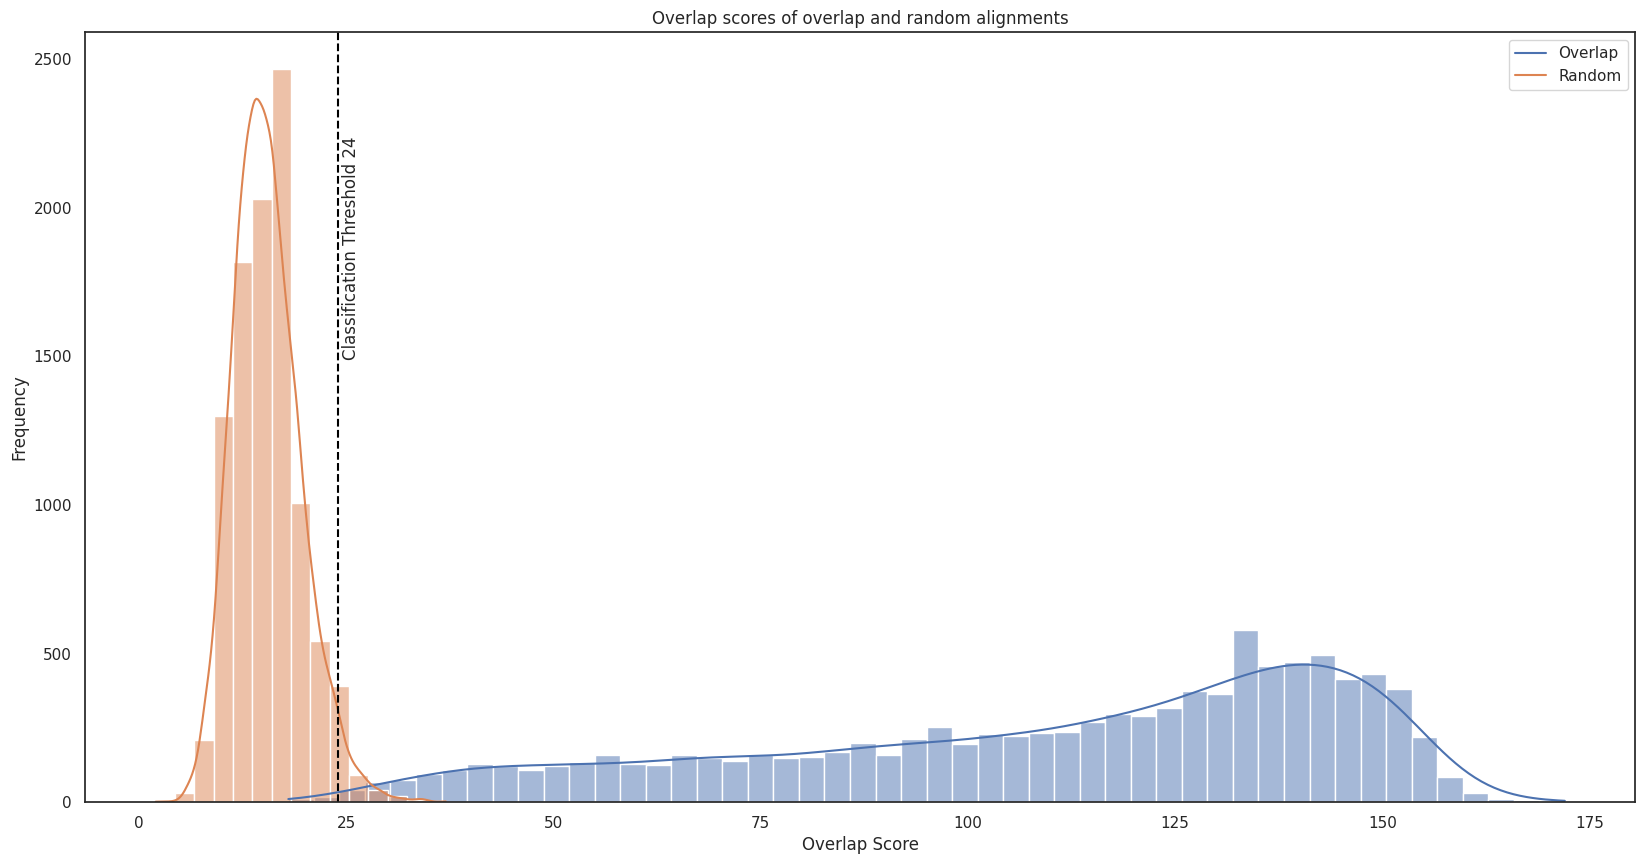

In [13]:
# Plot only overlap_final_scores and random_final_scores
sns.set(style="white")
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(overlap_final_scores, kde=True, ax=ax, bins=50)
sns.histplot(random_final_scores, kde=True, ax=ax, bins=15)
plt.title("Overlap scores of overlap and random alignments")
plt.xlabel("Overlap Score")
plt.ylabel("Frequency")
plt.legend(["Overlap", "Random"])
# Add x=24
plt.axvline(x=24, color="black", linestyle="--")
plt.text(24.5,1500,'Classification Threshold 24',rotation=90)
plt.show()


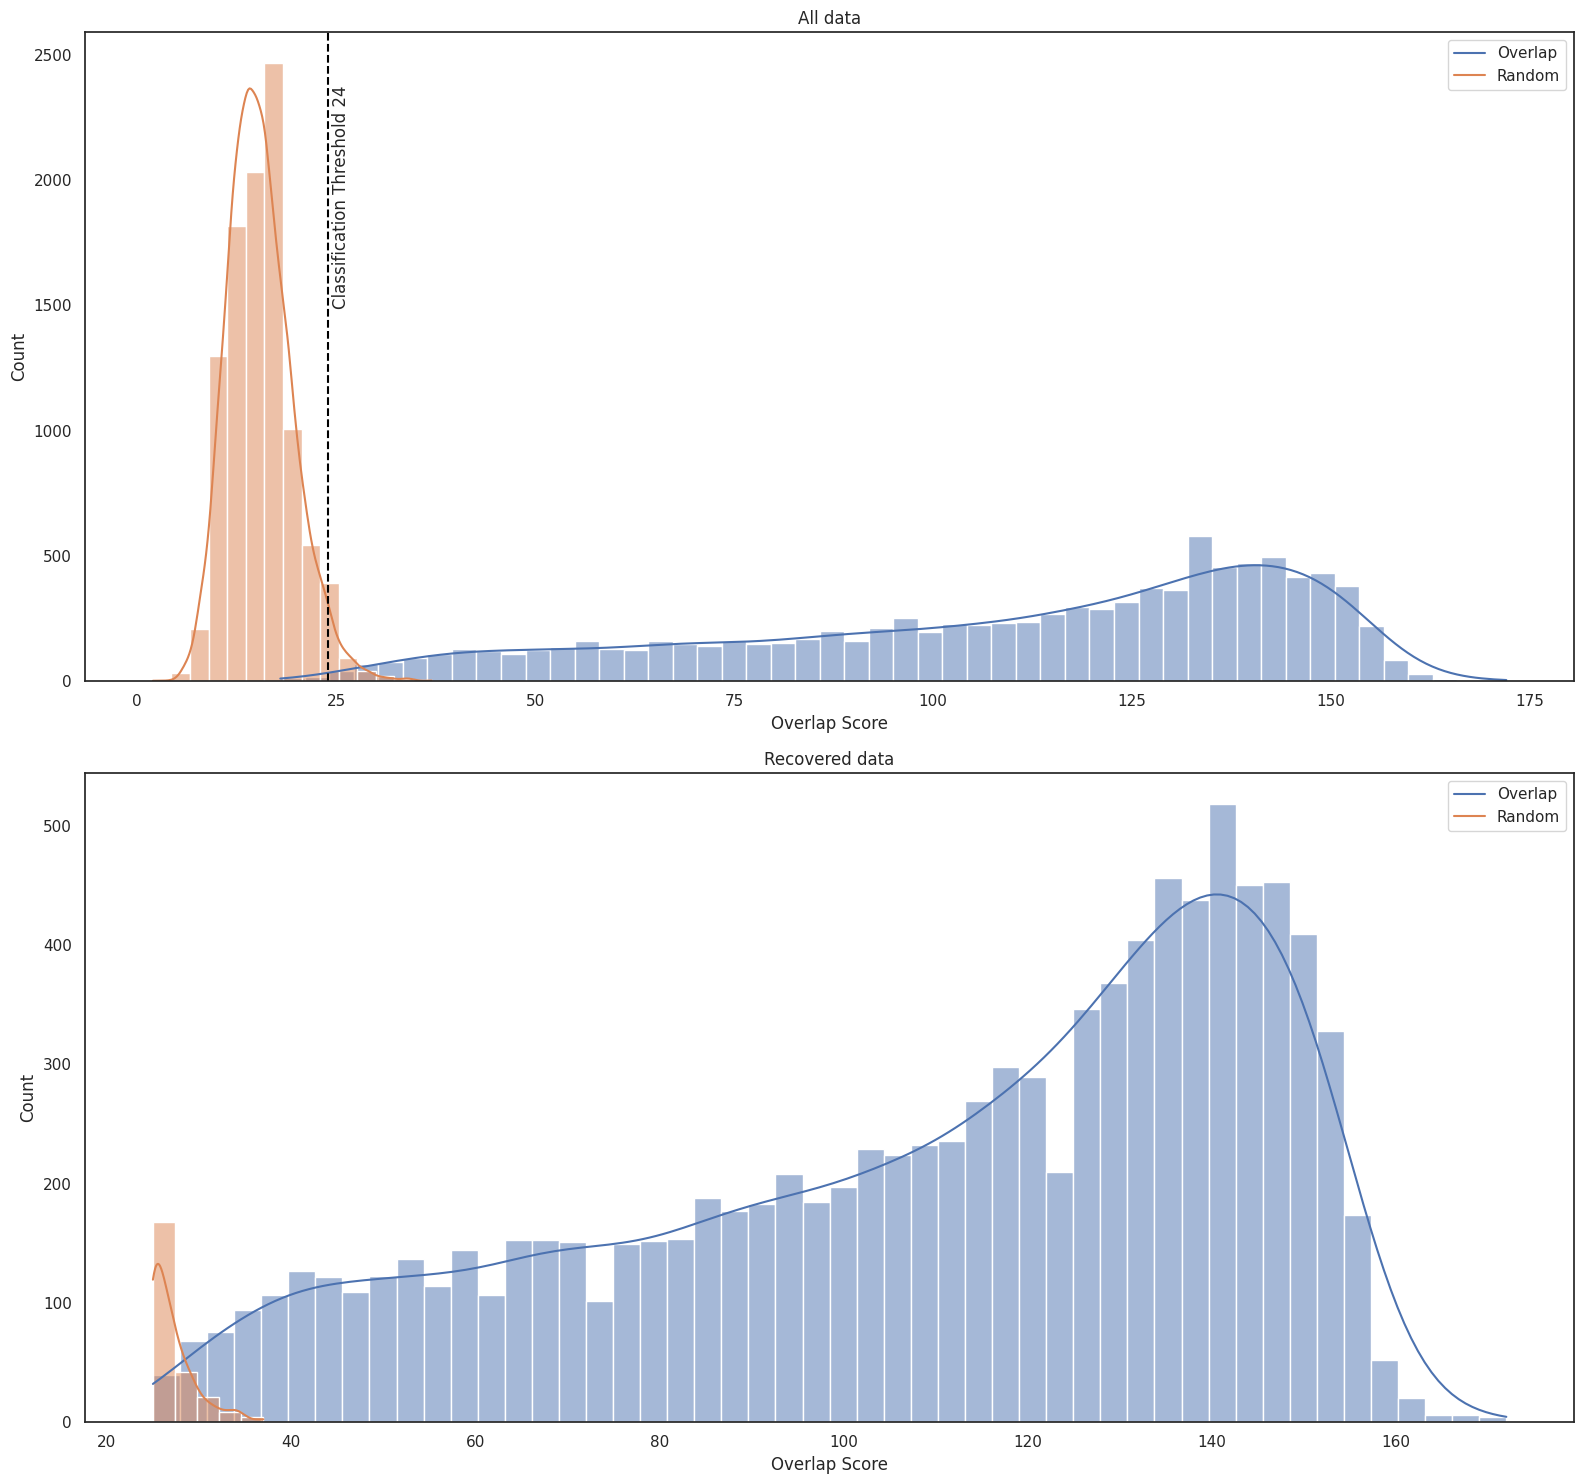

In [15]:
# Frequency plot of overlap_final_scores and random_final_scores and overlap_final_scores_filtered and random_final_scores_filtered in 
fig, ax = plt.subplots(2, 1, figsize=(16, 15))
sns.histplot(overlap_final_scores, kde=True, ax=ax[0], bins=50)
sns.histplot(random_final_scores, kde=True, ax=ax[0], bins=15)
ax[0].set_title("All data")
ax[0].set_xlabel("Overlap Score")
ax[0].set_ylabel("Count")
# Add x=24
ax[0].axvline(x=24, color="black", linestyle="--", label="x=24")
ax[0].text(24.5,1500,'Classification Threshold 24',rotation=90)
sns.histplot(overlap_final_scores_filtered, kde=True, ax=ax[1], bins=50)
sns.histplot(random_final_scores_filtered, kde=True, ax=ax[1], bins=5)
# Same y-axis for both plots
# ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title("Recovered data")
ax[1].set_xlabel("Overlap Score")
ax[1].set_ylabel("Count")
# Add legend
ax[0].legend(["Overlap", "Random"])
ax[1].legend(["Overlap", "Random"])
# Reduce the whitespace at the left/right of the plot
plt.tight_layout()
plt.show()
# Save 400dpi
fig.savefig("final_score_frequency.png", dpi=400)


## Algorithm Evaluation

In [16]:
algo_results= os.listdir("/new-stg/home/banghua/Pavel/results/Algorithm")

algo_results_by_sim = {
    "sim_0": [i for i in algo_results if "sim_0" in i],
    "sim_1": [i for i in algo_results if "sim_1" in i],
    "sim_2": [i for i in algo_results if "sim_2" in i],
    "sim_3": [i for i in algo_results if "sim_3" in i],
    "sim_4": [i for i in algo_results if "sim_4" in i],
    "sim_5": [i for i in algo_results if "sim_5" in i],
    "sim_6": [i for i in algo_results if "sim_6" in i],
    "sim_7": [i for i in algo_results if "sim_7" in i],
    "sim_8": [i for i in algo_results if "sim_8" in i],
    "sim_9": [i for i in algo_results if "sim_9" in i],
}

algo_results_by_k = {
    "k_1": [i for i in algo_results if "_k1_" in i],
    "k_2": [i for i in algo_results if "_k2_" in i],
    "k_3": [i for i in algo_results if "_k3_" in i],
    "k_4": [i for i in algo_results if "_k4_" in i],
    "k_5": [i for i in algo_results if "_k5_" in i],
    "k_6": [i for i in algo_results if "_k6_" in i],
    "k_7": [i for i in algo_results if "_k7_" in i],
    "k_8": [i for i in algo_results if "_k8_" in i],
    "k_9": [i for i in algo_results if "_k9_" in i],
    "k_10": [i for i in algo_results if "_k10_" in i],
}

def load_algo_result(path):
    with open(f"/new-stg/home/banghua/Pavel/results/Algorithm/{path}", "r") as f:
        return json.load(f)

In [26]:
import pandas as pd

summary_df = pd.DataFrame(columns=["sim", "k", "time_brute_force", "time_greedy", "brute_force_coverage", "greedy_coverage"])

for f in algo_results:
    data = load_algo_result(f)
    sim = f.split("_")[1]
    k = f.split("_")[3]
    k = int(k[1:])
    time_brute_force = data["time_brute_force"]
    time_greedy = data["time_greedy"]
    brute_force_num_covered = data["brute_force_num_covered"]
    greedy_num_recovered = data["greedy_num_recovered"]
    total_reads = data["total_reads"]
    brute_force_covered_ratio = brute_force_num_covered / total_reads
    greedy_recovered_ratio = greedy_num_recovered / total_reads
    summary_df = pd.concat([summary_df, pd.DataFrame([[sim, k, time_brute_force, time_greedy, brute_force_covered_ratio, greedy_recovered_ratio]], columns=summary_df.columns)], ignore_index=True)
    

/tmp/ipykernel_3914484/2776484124.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame([[sim, k, time_brute_force, time_greedy, brute_force_covered_ratio, greedy_recovered_ratio]], columns=summary_df.columns)], ignore_index=True)


In [27]:
summary_df

,sim,k,time_brute_force,time_greedy,brute_force_coverage,greedy_coverage
0,5,2,0.002009,0.000593,0.807692,0.807692
1,9,9,25.451443,0.001022,1.000000,1.000000
2,9,6,2.126843,0.000798,0.960929,0.960929
3,4,2,0.002102,0.000722,0.740260,0.698701
4,8,9,144.980271,0.001222,1.000000,1.000000
...,...,...,...,...,...,...
95,5,1,0.000235,0.000436,0.564835,0.564835
96,9,5,0.589342,0.000736,0.914467,0.914467
97,2,3,0.056248,0.000745,0.830601,0.830601
98,4,1,0.000229,0.000524,0.447619,0.447619


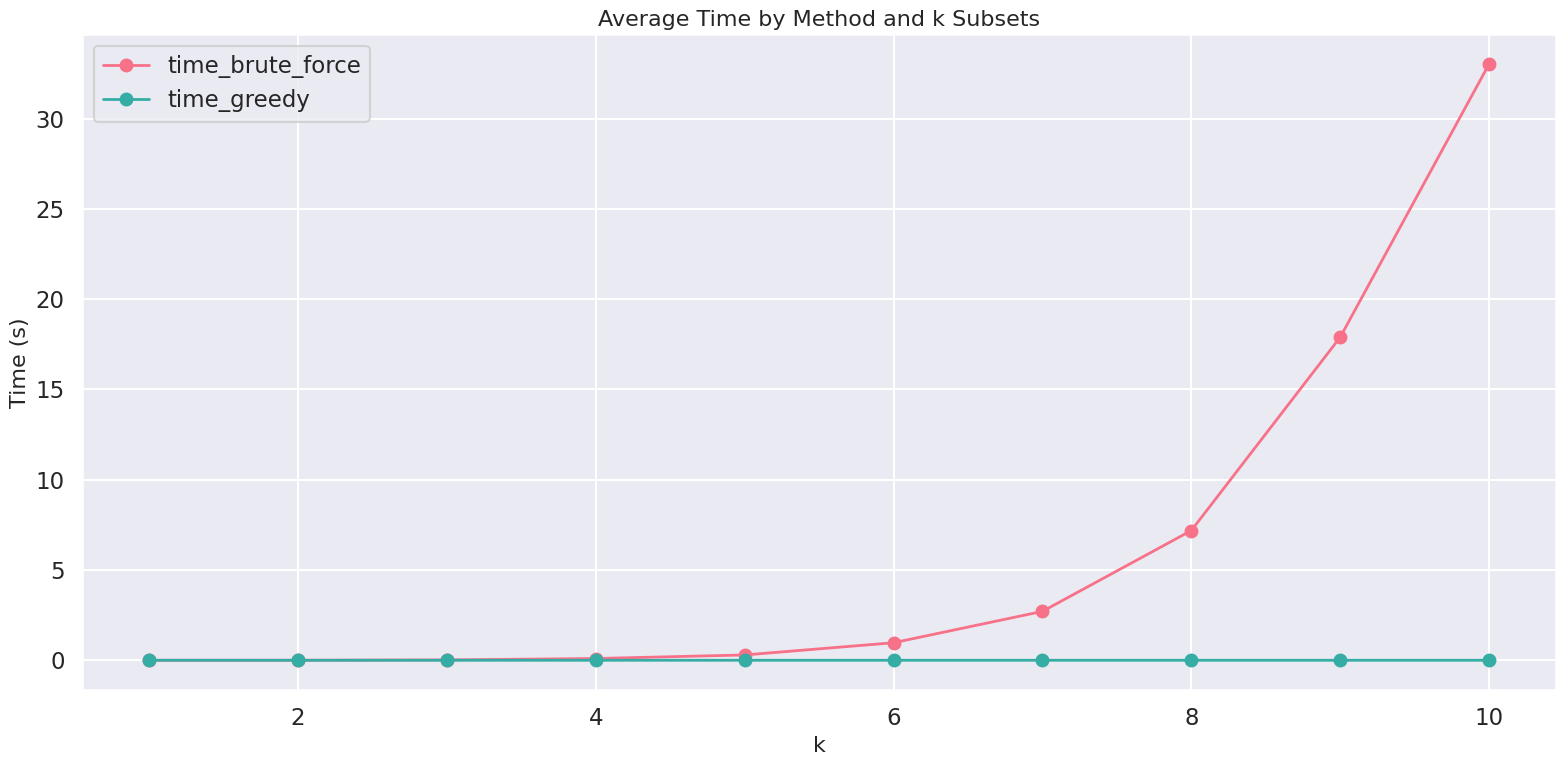

In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming summary_df is already defined and loaded with your data
# If not, you need to define or load summary_df here

# Setting the background to white with grid lines
sns.set(style="darkgrid", context="talk")

fig, ax = plt.subplots(figsize=(16, 8))
clrs = sns.color_palette("husl", 2)  # Two colors for the two lines

for idx, (time_column, clr) in enumerate(zip(["time_brute_force", "time_greedy"], clrs)):
    # Calculate mean for each 'k' value across all 'sim' values
    mean_values = summary_df.groupby("k")[time_column].mean()

    # Plotting
    ax.plot(mean_values.index, mean_values, label=time_column, color=clr, marker='o', linestyle='-', linewidth=2)

ax.set_xlabel('k', fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
ax.legend()
plt.title('Average Time by Method and k Subsets', fontsize=16)
plt.tight_layout()
plt.show()

# Save 400dpi
fig.savefig("average_time_by_method_and_k_subsets.png", dpi=400)

In [28]:
summary_df

,sim,k,time_brute_force,time_greedy,brute_force_coverage,greedy_coverage
0,5,2,0.002009,0.000593,0.807692,0.807692
1,9,9,25.451443,0.001022,1.000000,1.000000
2,9,6,2.126843,0.000798,0.960929,0.960929
3,4,2,0.002102,0.000722,0.740260,0.698701
4,8,9,144.980271,0.001222,1.000000,1.000000
...,...,...,...,...,...,...
95,5,1,0.000235,0.000436,0.564835,0.564835
96,9,5,0.589342,0.000736,0.914467,0.914467
97,2,3,0.056248,0.000745,0.830601,0.830601
98,4,1,0.000229,0.000524,0.447619,0.447619


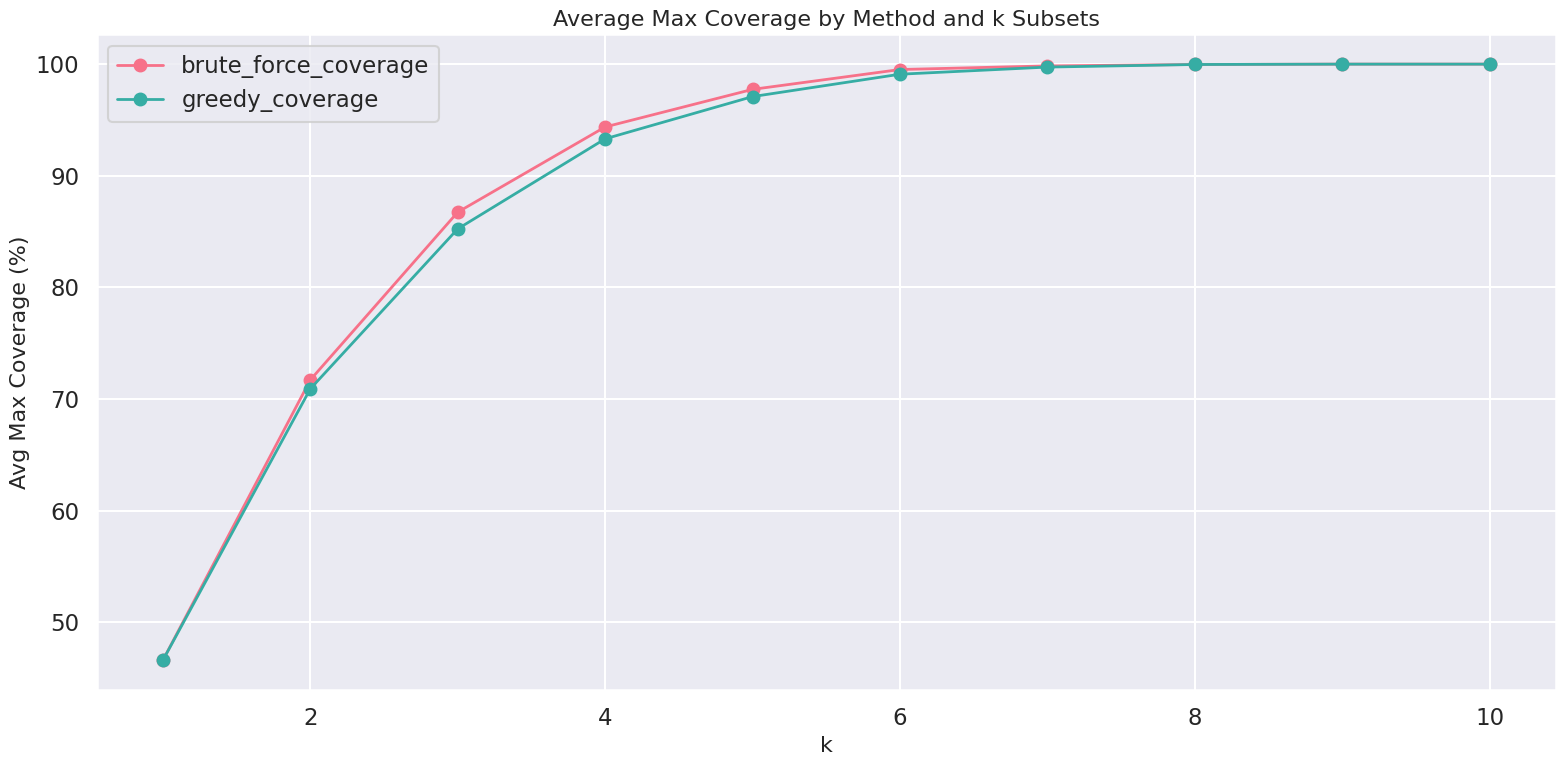

In [32]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming summary_df is already defined and loaded with your data
# If not, you need to define or load summary_df here

# Setting the background to dark with grid lines
sns.set(style="darkgrid", context="talk")

fig, ax = plt.subplots(figsize=(16, 8))
clrs = sns.color_palette("husl", 2)  # Two colors for the two lines

# Update the column names to 'brute_force_covered_ratio' and 'greedy_recovered_ratio'
for idx, (coverage_column, clr) in enumerate(zip(["brute_force_coverage", "greedy_coverage"], clrs)):
    # Calculate mean for each 'k' value across all 'sim' values
    mean_values = summary_df.groupby("k")[coverage_column].mean()

    # Plotting
    ax.plot(mean_values.index, mean_values * 100, label=coverage_column, color=clr, marker='o', linestyle='-', linewidth=2)  # Multiply by 100 to convert to percentage

ax.set_xlabel('k', fontsize=16)
ax.set_ylabel('Avg Max Coverage (%)', fontsize=16)
ax.legend()
plt.title('Average Max Coverage by Method and k Subsets', fontsize=16)
plt.tight_layout()
plt.show()

# Save 400dpi
fig.savefig("average_max_coverage_by_method_and_k_subsets.png", dpi=400)

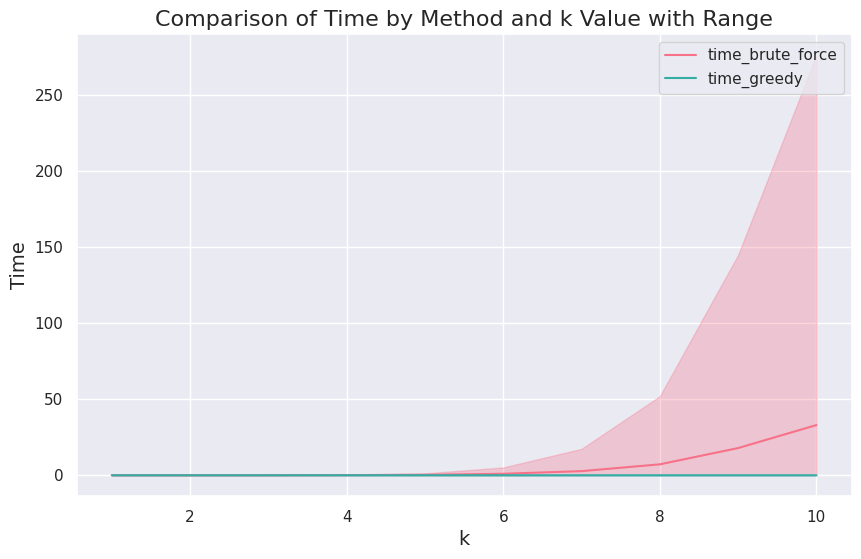

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming summary_df is already defined and loaded with your data, 
# the following is an illustrative example with generated data
fig, ax = plt.subplots(figsize=(10, 6))
clrs = sns.color_palette("husl", 2)  # Two colors for the two lines

# Plot settings
with sns.axes_style("darkgrid"):
    for idx, (time_column, clr) in enumerate(zip(["time_brute_force", "time_greedy"], clrs)):
        # Calculate mean, max, and min for each 'k' value across all 'sim' values
        grouped = summary_df.groupby("k")[time_column].agg(['mean', 'min', 'max'])
        
        # Plotting
        ax.plot(grouped.index, grouped['mean'], label=time_column, color=clr)
        ax.fill_between(grouped.index, grouped['min'], grouped['max'], alpha=0.3, color=clr)

    ax.set_xlabel('k', fontsize=14)
    ax.set_ylabel('Time', fontsize=14)
    ax.legend()
    plt.title('Comparison of Time by Method and k Value with Range', fontsize=16)

plt.show()
